# Приведение датасета под формата YOLO (ДЕЛАЛОСЬ ЛОКАЛЬНО!! ДЛЯ РАБОТЫ В КОЛЛАБЕ НУЖНО ИЗМЕНИТЬ ПУТИ! НЕ ПРОВЕРЯЛОСЬ В КОЛЛАБЕ!)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import cv2
import os

## Подготовка датасета

In [ ]:
data = pd.read_csv('./data/labels.csv')

In [ ]:
images_with_cars = data.image.to_list()

In [ ]:
all_images = os.listdir('./data/images')

In [ ]:
y = []
for image in all_images:
    if image in images_with_cars:
        y.append(1)
    else:
        y.append(0)

In [ ]:
image_ratio = sum(y) / len(y)

print(f'Процент изображений содержащих один или более объект: {round(image_ratio, 2) * 100}%')

Процент изображений содержащих один или более объект: 35.0%


In [ ]:
multi_images = data.groupby('image').count()
multi_images = multi_images.loc[multi_images['xmin'] > 1]

images_with_multiple_instances = multi_images.reset_index().image.tolist()

print(f'Количество изображений содержащих несколько объектов: {len(images_with_multiple_instances)}')

Количество изображений содержащих несколько объектов: 119


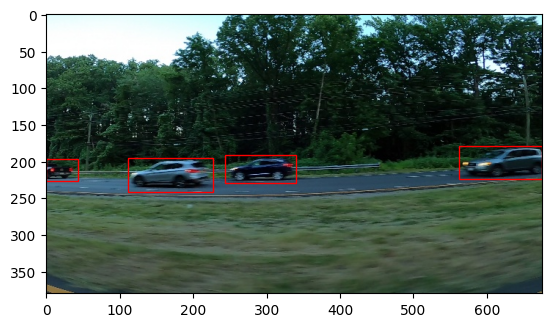

In [ ]:
test = data.loc[data['image'] == 'vid_4_9620.jpg'] # Пример изображения с нескольими автомобилями

img = cv2.imread('./data/images/vid_4_9620.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

for box in test.itertuples():
    xmin = box.xmin
    ymin = box.ymin
    xmax = box.xmax
    ymax = box.ymax

    # Create a Rectangle patch
    rect = patches.Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

Т.к. только 35% изображений содержат объекты, будет разумным раздеить выборку на трейн и тест с учетом распределения, чтобы не переобучить модель и сохранить ожидание естественного расределения

y_train и y_test всеголишь массиввы с метками 1 - изображение с объектом, 0 - изображение без объекта. Далее нужны будут только X_train и X_test - названия соответствующих изображений

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(all_images).reshape(-1, 1)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=42, stratify=y_test) # Cоздание вадидационных данных

In [ ]:
sum(y_train) / len(y_train), sum(y_test) / len(y_test)

(0.35522388059701493, 0.35353535353535354)

In [ ]:
X_train = X_train.reshape(-1)
X_test = X_test.reshape(-1)
X_val = X_val.reshape(-1)

Разделение на train и val

In [ ]:
TRAIN_IMAGES_PATH = './data/yolo_format/images/train/'
VAL_IMAGES_PATH = './data/yolo_format/images/val/'
TEST_IMAGES_PATH = './data/yolo_format/images/test/' # ВАЖНО! В терминах yolo: val - валидация метрик, test - чистый тест на неизвестных данных!

TRAIN_LABELS_PATH = './data/yolo_format/labels/train/'
VAL_LABELS_PATH = './data/yolo_format/labels/val/'
TEST_LABELS_PATH = './data/yolo_format/labels/test/'

CAR_CLASS_LABEL = 0

In [ ]:
for image in X_train:
    if image not in os.listdir(TRAIN_IMAGES_PATH):
        img = cv2.imread(f'./data/images/{image}')
        image_height, image_width, _ = img.shape
        cv2.imwrite(TRAIN_IMAGES_PATH + image, img)

    with open(TRAIN_LABELS_PATH + image[:-4] + '.txt', 'w') as f:
        image_data = data.loc[data['image'] == image]
        for box in image_data.itertuples():
            x_center = ((box.xmax + box.xmin) / 2.0) / image_width
            y_center = ((box.ymax + box.ymin) / 2.0) / image_height
            width = (box.xmax - box.xmin) / image_width
            height = (box.ymax - box.ymin) / image_height
            f.write(f'{CAR_CLASS_LABEL} {x_center} {y_center} {width} {height}\n')

In [ ]:
for image in X_test:
    if image not in os.listdir(VAL_IMAGES_PATH):
        img = cv2.imread(f'./data/images/{image}')
        image_height, image_width, _ = img.shape
        cv2.imwrite(VAL_IMAGES_PATH + image, img)

    with open(VAL_LABELS_PATH + image[:-4] + '.txt', 'w') as f:
        image_data = data.loc[data['image'] == image]
        for box in image_data.itertuples():
            x_center = ((box.xmax + box.xmin) / 2.0) / image_width
            y_center = ((box.ymax + box.ymin) / 2.0) / image_height
            width = (box.xmax - box.xmin) / image_width
            height = (box.ymax - box.ymin) / image_height
            f.write(f'{CAR_CLASS_LABEL} {x_center} {y_center} {width} {height}\n')

In [ ]:
for image in X_val:
    if image not in os.listdir(TEST_IMAGES_PATH):
        img = cv2.imread(f'./data/images/{image}')
        image_height, image_width, _ = img.shape
        cv2.imwrite(TEST_IMAGES_PATH + image, img)

    with open(TEST_LABELS_PATH + image[:-4] + '.txt', 'w') as f:
        image_data = data.loc[data['image'] == image]
        for box in image_data.itertuples():
            x_center = ((box.xmax + box.xmin) / 2.0) / image_width
            y_center = ((box.ymax + box.ymin) / 2.0) / image_height
            width = (box.xmax - box.xmin) / image_width
            height = (box.ymax - box.ymin) / image_height
            f.write(f'{CAR_CLASS_LABEL} {x_center} {y_center} {width} {height}\n')

In [ ]:
import yaml

d = {
    'path': './data/yolo_format/',
    'train': '/images/train/',
    'val': '/images/val/',
    'test': '/images/test/',
    'names': {CAR_CLASS_LABEL: 'car'}
}

with open('./data/yolo_format/data.yaml', 'w') as outfile:
    yaml.dump(d, outfile, default_flow_style=False)

# Настройка параметров для обучения

In [1]:
ROOT = '/content/drive/MyDrive/Complex Systems/data'

In [2]:
import os

os.listdir(ROOT)

['labels.csv', 'yolo_format', 'images', '.ipynb_checkpoints', 'train']

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.1/112.6 GB disk)


In [4]:
DATASET_PATH = ROOT + '/yolo_format/data.yaml'
PROJECT_PATH = ROOT + '/train/'

TRAIN_IMAGES_PATH = ROOT + '/yolo_format/images/train/'
VAL_IMAGES_PATH = ROOT + '/yolo_format/images/val/'
TEST_IMAGES_PATH = ROOT + '/yolo_format/images/test/' # ВАЖНО! В терминах yolo: val - валидация метрик, test - чистый тест на неизвестных данных!

TRAIN_LABELS_PATH = ROOT + '/yolo_format/labels/train/'
VAL_LABELS_PATH = ROOT + '/yolo_format/labels/val/'
TEST_LABELS_PATH = ROOT + '/yolo_format/labels/test/'

## Подключение логера

In [ ]:
#!pip install clearml

#import clearml

#clearml.browser_login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.10.1
    Uninstalling PyJWT-2.10.1:
      Successfully uninstalled PyJWT-2.10.1


<IPython.core.display.Javascript object>

ClearML automatic browser login failed, please login or create a new account
To get started with ClearML: setup your own `clearml-server`, or create a free account at https://app.clear.ml

Please login to https://app.clear.ml , then press [Enter] to connect 


<IPython.core.display.Javascript object>


We cannot connect automatically (adblocker / incognito?) 😟 
Please go to https://app.clear.ml/settings/workspace-configuration 
Then press  + Create new credentials  
And copy/paste your Access Key here: 2O4F2MWLDIPJ6VWOHTDIGC0C4OODOT
 Setting access key 
Now copy/paste your Secret Key here: 0QVrx0p14LITePlR5zp7Euo_4ucb0tTzngNA5P815QpSB_tOpsrqlX1wukQCwfauzPw
 Setting secret key 


Hurrah! 🥳 🎊 🎉
🤖 ClearML connected successfully - let's build something! 🚀


## Создание файла датасета

In [ ]:
import yaml

d = {
    'path': ROOT + '/yolo_format',
    'train': ROOT + '/yolo_format' + '/images/train/',
    'val': ROOT + '/yolo_format' + '/images/val/',
    'test': ROOT + '/yolo_format' + '/images/test/',
    'names': {0: 'car'}
}

with open(DATASET_PATH, 'w') as outfile:
    yaml.dump(d, outfile, default_flow_style=False)

# Обучение

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")

results = model.train(data=DATASET_PATH, epochs=100, device=0, project=PROJECT_PATH)

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.2MB/s]


Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/Complex Systems/data/yolo_format/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/Complex Systems/data/train/, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fa

100%|██████████| 755k/755k [00:00<00:00, 22.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/train... 670 images, 432 backgrounds, 0 corrupt: 100%|██████████| 670/670 [01:59<00:00,  5.59it/s]


train: New cache created: /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/val... 297 images, 192 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:50<00:00,  5.83it/s]


val: New cache created: /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/val.cache
Plotting labels to /content/drive/MyDrive/Complex Systems/data/train/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Complex Systems/data/train/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.56G      1.513      3.439      1.196         20        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        297        164    0.00181      0.982     0.0734     0.0207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.37G      1.432      2.454      1.221         16        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


                   all        297        164          1        0.3      0.925       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.37G      1.446      1.975      1.213         24        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


                   all        297        164      0.893      0.767        0.9      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.36G      1.426      1.853      1.235         16        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


                   all        297        164      0.936      0.915      0.955      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.35G      1.427      1.408      1.231         19        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


                   all        297        164      0.721      0.622       0.68      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.36G      1.375      1.299      1.174         17        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


                   all        297        164      0.965      0.841       0.95      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.35G      1.394      1.135       1.21          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        297        164      0.958      0.976      0.981      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.37G      1.342      1.036      1.198         11        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        297        164        0.5      0.341      0.373      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.35G      1.385     0.9848      1.209         22        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

                   all        297        164      0.826      0.756       0.83       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.36G      1.342     0.9639      1.199         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        297        164      0.972      0.939      0.978      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.35G      1.356      0.912      1.216         20        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

                   all        297        164      0.916      0.932      0.973       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.36G      1.321     0.8636      1.206         11        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        297        164      0.949      0.906      0.971      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.35G      1.317     0.8471      1.185          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        297        164      0.666      0.488      0.578      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.38G      1.301     0.8131      1.194         20        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]

                   all        297        164      0.949      0.939      0.977      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.35G      1.302     0.7746       1.19          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.87it/s]

                   all        297        164      0.981       0.93       0.98      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.36G      1.288     0.7574      1.178         15        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

                   all        297        164      0.959      0.957      0.979      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.35G      1.296      0.755      1.159          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]

                   all        297        164      0.957      0.949      0.982      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.37G      1.297     0.7737      1.196         23        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        297        164      0.957      0.953      0.989       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.35G      1.254     0.7231      1.154          8        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

                   all        297        164      0.946      0.955      0.981       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.36G      1.287     0.7242      1.177         27        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]

                   all        297        164      0.969      0.951      0.981      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G      1.229     0.7121      1.137         20        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        164      0.968      0.933      0.981      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.36G      1.259     0.6983      1.172         26        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        297        164      0.974      0.951       0.97      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.35G      1.255     0.7015      1.167         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

                   all        297        164      0.966      0.963      0.982      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.37G      1.226     0.6864      1.155         16        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        297        164       0.97      0.933      0.983      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.35G      1.231      0.696      1.151         23        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        297        164      0.976      0.975      0.985      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.35G      1.192     0.6489      1.134         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

                   all        297        164      0.968      0.963      0.986      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.35G      1.192     0.6427      1.127          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

                   all        297        164      0.975       0.97      0.986      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.36G      1.176     0.6323      1.129         14        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        297        164       0.97      0.972      0.986      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.35G      1.168     0.6484      1.112         11        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        297        164      0.981      0.962      0.987      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.36G      1.204     0.6411      1.117         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        297        164      0.976      0.963      0.979      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.36G      1.205     0.6426      1.144          7        640: 100%|██████████| 42/42 [00:18<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        297        164      0.982      0.951       0.99      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.36G      1.236     0.6348       1.13         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        297        164      0.978      0.933      0.983      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.35G      1.121     0.6082      1.107         19        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        297        164       0.97      0.921      0.979      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.36G      1.151      0.617      1.103         13        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        297        164      0.983      0.939      0.986      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.35G      1.161     0.6163      1.096         23        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

                   all        297        164      0.994      0.949      0.982      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.36G      1.183     0.6371      1.127         22        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        297        164      0.994      0.968      0.987       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.35G      1.195     0.6152      1.129         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

                   all        297        164      0.986      0.957      0.984      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.36G      1.177     0.5924      1.122          9        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        297        164      0.985      0.957      0.986      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.35G      1.128     0.5822        1.1         16        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        297        164      0.966      0.963      0.987      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.37G      1.131     0.5897      1.099         21        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

                   all        297        164      0.988       0.97      0.988      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.35G      1.164     0.6008      1.119          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.60it/s]

                   all        297        164      0.975      0.968      0.988      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.36G      1.132     0.5774      1.101         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        297        164       0.97      0.983      0.987      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.35G      1.155     0.5983      1.102         21        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        164      0.982      0.982      0.986       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.36G      1.139     0.5661      1.101          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

                   all        297        164       0.98       0.97      0.987      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.35G      1.137     0.5926      1.089         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]

                   all        297        164      0.981      0.948      0.986      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.35G      1.093      0.557      1.075         13        640: 100%|██████████| 42/42 [00:18<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        297        164      0.974       0.97      0.992      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.35G      1.085     0.5732      1.091         15        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

                   all        297        164      0.978       0.97      0.986      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.37G      1.112     0.5763      1.104         12        640: 100%|██████████| 42/42 [00:18<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

                   all        297        164          1      0.962      0.988      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.35G      1.107     0.5687      1.083          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

                   all        297        164          1      0.963      0.987      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.37G       1.11     0.5745      1.104         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]

                   all        297        164      0.981      0.955      0.989      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.35G      1.124     0.5589      1.101         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        297        164      0.982      0.963      0.983      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.36G      1.116     0.5571      1.093         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

                   all        297        164       0.98      0.963      0.986       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.35G       1.06     0.5432      1.051         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

                   all        297        164      0.961       0.97      0.986      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.36G      1.077     0.5431      1.074         16        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        297        164      0.985      0.951      0.986       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.37G      1.088      0.535      1.095         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

                   all        297        164      0.968      0.963      0.986      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.36G      1.102     0.5457      1.092         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]

                   all        297        164      0.976       0.98       0.99      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.35G      1.082     0.5602      1.076         20        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

                   all        297        164      0.968       0.97      0.987      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.36G      1.033     0.5206      1.067         11        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        297        164      0.981      0.976       0.99      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.35G       1.07      0.534      1.076         14        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]

                   all        297        164      0.992      0.963      0.993      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.36G      1.049     0.5317      1.069         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        297        164      0.976      0.982       0.99      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.35G      1.065      0.534      1.077         14        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        164       0.98      0.982       0.99      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.37G      1.058     0.5296      1.085         14        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        297        164      0.984      0.976      0.988      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.35G       1.04     0.5416      1.068         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        297        164      0.994      0.976      0.989      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.36G      1.053     0.5144      1.061         11        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]

                   all        297        164      0.988      0.976      0.991      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.35G      1.033     0.5093      1.067         20        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

                   all        297        164      0.994      0.971      0.993      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.36G      1.015     0.5078      1.051          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]

                   all        297        164      0.994      0.965       0.99      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.35G     0.9948      0.512      1.049         12        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        297        164      0.988       0.97      0.994      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.36G      1.015     0.5222      1.066          9        640: 100%|██████████| 42/42 [00:18<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

                   all        297        164      0.992      0.976      0.988      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.35G      1.005     0.5104      1.063         16        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        297        164      0.992       0.97      0.991      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.36G     0.9932     0.4909       1.05         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

                   all        297        164      0.986       0.97      0.991      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.35G      1.009     0.5011      1.042         25        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]

                   all        297        164      0.969      0.982      0.988      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.35G     0.9948     0.5078      1.053         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]

                   all        297        164      0.993      0.976      0.993      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.35G     0.9912     0.4944      1.032         15        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]

                   all        297        164       0.99       0.97      0.988       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.36G     0.9553      0.479      1.031         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        297        164      0.988      0.976      0.993      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.35G     0.9737     0.4878      1.027         26        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        297        164      0.984       0.97      0.987      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.36G     0.9895     0.4901      1.034         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

                   all        297        164      0.986      0.982      0.992      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.35G     0.9893     0.4782      1.048          9        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

                   all        297        164      0.994      0.975      0.989      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.36G     0.9761     0.4792      1.045         10        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

                   all        297        164      0.988      0.974      0.993       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.35G     0.9501     0.4749      1.028         12        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        297        164      0.987      0.982      0.993      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.36G     0.9894     0.5021      1.053         18        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]

                   all        297        164      0.987      0.982      0.993      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.35G     0.9773     0.4798      1.031         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

                   all        297        164      0.991      0.963      0.992      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.36G     0.9805     0.4768      1.038         17        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

                   all        297        164      0.988      0.981      0.993      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.35G     0.9566     0.4692      1.031         21        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

                   all        297        164      0.988      0.981      0.992      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.36G     0.9305     0.4653      1.024         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

                   all        297        164      0.994       0.97      0.993      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.35G     0.9343     0.4624      1.027         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

                   all        297        164      0.997       0.97      0.992      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.36G     0.9151     0.4656      1.015         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

                   all        297        164      0.984      0.976      0.989      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.35G     0.9376     0.4669      1.017         20        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]

                   all        297        164      0.993      0.963       0.99      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.36G     0.9489     0.4753      1.046         21        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]

                   all        297        164      0.994      0.973      0.993      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.37G     0.9654     0.4608      1.034         12        640: 100%|██████████| 42/42 [00:16<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

                   all        297        164          1      0.973      0.994      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.36G     0.9055     0.4445      1.008         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

                   all        297        164      0.998       0.97      0.992      0.698


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.42G      0.929      0.469      1.039          5        640: 100%|██████████| 42/42 [00:19<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

                   all        297        164      0.996       0.97      0.991      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.35G     0.8945     0.4462      1.019          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

                   all        297        164      0.987       0.97      0.989      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.35G     0.9188     0.4432      1.034          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]

                   all        297        164      0.988      0.979      0.989      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.36G     0.9053     0.4536      1.022         10        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        297        164      0.982      0.987       0.99      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.36G     0.8868     0.4203      1.004          6        640: 100%|██████████| 42/42 [00:18<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

                   all        297        164      0.988      0.981      0.989      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.36G     0.8999     0.4442      1.017          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

                   all        297        164      0.988      0.983       0.99      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.35G     0.9234     0.4634      1.031          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

                   all        297        164          1      0.968       0.99      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.36G     0.8606     0.4457     0.9894         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        297        164      0.997       0.97      0.989      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.36G     0.8782     0.4207      1.012          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

                   all        297        164      0.998       0.97      0.989      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.36G     0.8697     0.4269      1.014          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

                   all        297        164      0.998       0.97       0.99      0.697



100 epochs completed in 0.642 hours.
Optimizer stripped from /content/drive/MyDrive/Complex Systems/data/train/train/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/Complex Systems/data/train/train/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/Complex Systems/data/train/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


                   all        297        164      0.986       0.97      0.991      0.705
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /content/drive/MyDrive/Complex Systems/data/train/train


# Валидация модели

In [ ]:
validation = model.val(plots=True, project=PROJECT_PATH, name='validation')

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/val.cache... 297 images, 192 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.56it/s]


                   all        297        164      0.986       0.97      0.991      0.705
Speed: 0.3ms preprocess, 5.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/Complex Systems/data/train/validation


# Валидация предобученной модели

In [5]:
# Изменить метки классов под стиль COCO!

for file in os.listdir(VAL_LABELS_PATH):
  with open(VAL_LABELS_PATH + file, 'r') as labels:
    lines = labels.readlines()
  with open(VAL_LABELS_PATH + file, 'w') as f:
    for line in lines:
      f.write('2' + line[1:])

In [5]:
import yaml

DATASET_PATH_PRETRAIN_VAL = ROOT + '/yolo_format/data_pretrain_val.yaml'

d = {
    'path': ROOT + '/yolo_format',
    'train': ROOT + '/yolo_format' + '/images/train/',
    'val': ROOT + '/yolo_format' + '/images/val/',
    'test': ROOT + '/yolo_format' + '/images/test/',
    'names': {0: 'person', 1: 'bycicle', 2: 'car'}
}

with open(DATASET_PATH_PRETRAIN_VAL, 'w') as outfile:
    yaml.dump(d, outfile, default_flow_style=False)

In [6]:
from ultralytics import YOLO

model = YOLO('yolo11n.pt')

metrics = model.val(data=DATASET_PATH_PRETRAIN_VAL, plots=True, project=PROJECT_PATH, name='validation_pretrain', split='val')

Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


val: Scanning /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/val... 297 images, 192 backgrounds, 0 corrupt: 100%|██████████| 297/297 [00:03<00:00, 92.79it/s] 


val: New cache created: /content/drive/MyDrive/Complex Systems/data/yolo_format/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.91it/s]


                   all        297        164      0.884      0.887      0.908       0.32
                   car        105        164      0.884      0.887      0.908       0.32
Speed: 1.1ms preprocess, 3.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/Complex Systems/data/train/validation_pretrain2
